In [ ]:
%tensorflow_version 1.x

TensorFlow 1.x selected.


In [ ]:
import tensorflow as tf
from matplotlib import pyplot as plt

import pandas as pd

from sklearn.preprocessing import Normalizer
from sklearn.decomposition import PCA

In [ ]:
dataset = pd.read_csv("E202-COMP7117-TD01-00 - clustering.csv")

In [ ]:
features = dataset[["SpecialDay", "VisitorType", "Weekend", "ProductRelated_Duration", "ExitRates"]]
features.head(5)

,SpecialDay,VisitorType,Weekend,ProductRelated_Duration,ExitRates
0,LOW,Returning_Visitor,False,0,3
1,LOW,Returning_Visitor,False,0,3
2,LOW,Returning_Visitor,False,0,3
3,LOW,Returning_Visitor,False,0,3
4,LOW,Returning_Visitor,True,1,2


In [ ]:
#Features Extraction
features = dataset[["SpecialDay", "VisitorType", "Weekend", "ProductRelated_Duration", "ExitRates"]]
sz = len(features)

print(sz)

tmp = []

for i in range(sz):
  if (features["SpecialDay"].loc[i] == 'HIGH'):
    tmp.append(2)
  elif (features["SpecialDay"].loc[i] == 'NORMAL'):
    tmp.append(1)
  elif (features["SpecialDay"].loc[i] == 'LOW'):
    tmp.append(0)
features.drop(columns=["SpecialDay"])
features["SpecialDay"] = tmp

tmp = []

for i in range(sz):
  if (features["VisitorType"].loc[i] == 'Returning_Visitor'):
    tmp.append(2)
  elif (features["VisitorType"].loc[i] == 'New_Visitor'):
    tmp.append(1)
  elif (features["VisitorType"].loc[i] == 'Other'):
    tmp.append(0)

features.drop(columns=["VisitorType"])
features["VisitorType"] = tmp

tmp = []

for i in range(sz):
  if (features["Weekend"].loc[i] == True):
    tmp.append(1)
  elif (features["Weekend"].loc[i] == False):
    tmp.append(0)

print(len(tmp))
features.drop(columns=["Weekend"])
features["Weekend"] = tmp

3632


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:30: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


3632


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:42: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
features.head(20)

,SpecialDay,VisitorType,Weekend,ProductRelated_Duration,ExitRates
0,0,2,0,0,3
1,0,2,0,0,3
2,0,2,0,0,3
3,0,2,0,0,3
4,0,2,1,1,2
5,0,2,0,1,1
6,1,2,0,0,3
7,0,2,1,0,3
8,2,2,0,0,3
9,1,2,0,1,1


In [ ]:
# Normalization
normalizer = Normalizer()
normal_data = normalizer.fit_transform(features)

In [ ]:
#PCA
pca = PCA(n_components=3)
pca = pca.fit(normal_data)

data = pca.transform(normal_data)

In [ ]:
class SOM:
  def __init__ (self, height, width, input_dimension):
    self.height = height
    self.width = width
    self.input_dimension = input_dimension
    self.location = [tf.to_float([y,x]) for y in range(height) for x in range(width)]

    self.weight = tf.Variable(tf.random_normal([width*height, input_dimension]))
    self.input = tf.placeholder(tf.float32, [input_dimension])

    bmu = self.get_bmu()

    self.updated_weight, self.rate_stacked = self.updt_neighbour(bmu)


  def get_bmu(self):
    sq_diff = tf.square(self.input - self.weight)
    dist = tf.sqrt(tf.reduce_mean(sq_diff, axis = 1))

    bmu_index = tf.argmin(dist)
    bmu_location = tf.to_float([tf.div(bmu_index, self.width), tf.mod(bmu_index, self.width)])

    return bmu_location
  
  def updt_neighbour(self, bmu):
    alfa = 0.1
    sigma = tf.to_float(tf.maximum(self.width,self.height)/2)

    sq_diff = tf.square(self.location-bmu)
    dist = tf.sqrt(tf.reduce_mean(sq_diff, axis = 1))

    neighbour_strength = tf.exp(tf.div(tf.negative(tf.square(dist)), 2*tf.square(sigma)))

    rate = neighbour_strength*alfa
    total_node = self.width * self.height
    rate_stacked = tf.stack([tf.tile(tf.slice(rate, [i],[1]),[self.input_dimension]) for i in range(total_node)])

    input_weigth_diff = tf.subtract(self.input, self.weight)
    weight_diff = tf.multiply(rate_stacked, input_weigth_diff)
    weight_new = tf.add(self.weight, weight_diff)

    return tf.assign(self.weight, weight_new), rate_stacked
  
  def train(self, dataset, epoch):
    init = tf.global_variables_initializer()

    with tf.Session() as sess:
      sess.run(init)

      for i in range(epoch):
        for data in dataset:
          sess.run(self.updated_weight, feed_dict = {self.input: data})
      cluster = [[] for i in range(self.height)]
      location = sess.run(self.location)
      weight = sess.run(self.weight)

      for i, loc in enumerate(location):
        cluster[int(loc[0])].append(weight[i])
      
      self.cluster = cluster

In [ ]:
# SOM Architecture

height = 5
width = 5
input_dimension = 3

som = SOM(height, width, input_dimension)


Instructions for updating:
Use `tf.cast` instead.
Instructions for updating:
Deprecated in favor of operator or tf.math.divide.


In [ ]:
# SOM Trainning

epoch = 5000

som.train(data, epoch)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


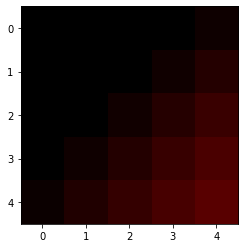

In [ ]:
som.cluster

plt.imshow(som.cluster)
plt.show()

In [ ]:
som.cluster

[[array([-0.2372747 , -0.07919236, -0.47213116], dtype=float32),
  array([-0.17192881, -0.08575603, -0.47232258], dtype=float32),
  array([-0.09944563, -0.09276242, -0.47112113], dtype=float32),
  array([-0.02223273, -0.09996201, -0.4684546 ], dtype=float32),
  array([ 0.05558777, -0.10682657, -0.46356773], dtype=float32)],
 [array([-0.1654088 , -0.08840168, -0.48084882], dtype=float32),
  array([-0.09263148, -0.09571197, -0.48105097], dtype=float32),
  array([-0.01438863, -0.10326647, -0.47983563], dtype=float32),
  array([ 0.06621367, -0.11079831, -0.47738633], dtype=float32),
  array([ 0.14461268, -0.11780229, -0.47340202], dtype=float32)],
 [array([-0.09229019, -0.09750987, -0.48842472], dtype=float32),
  array([-0.01424095, -0.10533878, -0.48858   ], dtype=float32),
  array([ 0.06694182, -0.11311974, -0.48714778], dtype=float32),
  array([ 0.14774472, -0.12060027, -0.48452356], dtype=float32),
  array([ 0.22367345, -0.12733956, -0.48069662], dtype=float32)],
 [array([-0.02091813, 

[[[3.0890599e-01 4.9640480e-01 3.0346677e-02]
  [3.8641164e-01 4.8861974e-01 3.0119637e-02]
  [4.7238272e-01 4.8030958e-01 3.1544656e-02]
  [5.6396365e-01 4.7177029e-01 3.4707386e-02]
  [6.5626526e-01 4.6362832e-01 4.0503617e-02]]

 [[3.9414495e-01 4.8548180e-01 2.0006811e-02]
  [4.8046488e-01 4.7681117e-01 1.9767046e-02]
  [5.7326740e-01 4.6785089e-01 2.1208538e-02]
  [6.6886842e-01 4.5891753e-01 2.4113616e-02]
  [7.6185620e-01 4.5061022e-01 2.8839331e-02]]

 [[4.8086968e-01 4.7467873e-01 1.1021163e-02]
  [5.7344258e-01 4.6539298e-01 1.0837001e-02]
  [6.6973209e-01 4.5616412e-01 1.2535721e-02]
  [7.6557106e-01 4.4729155e-01 1.5648257e-02]
  [8.5562885e-01 4.3929824e-01 2.0187333e-02]]

 [[5.6552291e-01 4.6462822e-01 4.2341291e-03]
  [6.6137940e-01 4.5496729e-01 3.9837589e-03]
  [7.5777107e-01 4.4579998e-01 5.9643094e-03]
  [8.5055089e-01 4.3734312e-01 9.4551397e-03]
  [9.3499577e-01 4.3000054e-01 1.4229952e-02]]

 [[6.4567006e-01 4.5600566e-01 8.3258760e-04]
  [7.4190849e-01 4.4603387

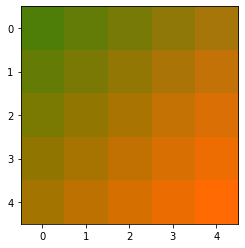

In [ ]:
# Visualization

res = som.cluster

mini = +1000000
maxi = -1000000

for i in range(height):
  for j in range(width):
    for k in range(input_dimension):
      mini = min(mini,res[i][j][k])
      maxi = max(maxi,res[i][j][k])

mini = -mini
res = res+mini
maxi = maxi+mini

for i in range(height):
  for j in range(width):
    for k in range(input_dimension):
      res[i][j][k] = res[i][j][k]/maxi
  
print(res)

plt.imshow(res)
plt.show()